In [2]:
import tensorflow as tf
import keras
import PIL
import matplotlib.pyplot as plt
import numpy as np
import shap
import tensorflow.compat.v1.keras.backend as K

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

print('Notebook running: tensorflow ', tf.__version__)
print('Notebook running: keras ', keras.__version__)
print('Notebook running: numpy ', np.__version__)

Notebook running: tensorflow  2.4.1
Notebook running: keras  2.4.3
Notebook running: numpy  1.19.5


In [3]:
#shap GradientExplainer compatibility

tf.compat.v1.disable_eager_execution()

In [4]:
#Loading model

model = tf.keras.models.load_model('C:\\Users\\samsn\\Documents\\Projects\\Thesis\\data\\model')

In [5]:
model.summary()

Model: "AkinolaVGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

This is a customized version of the VGG16 model created to recognize 3 type of objects: chimpanzee, gorilla and white tiger. This choice was made make more visible how the network works and what it "sees"

In [6]:
#setting class names

class_names={
    '0':'chimpanzee',
    '1':'gorilla',
    '2':'white_tiger'
}

In [7]:
#loading dataset and image

X,y = shap.datasets.imagenet50()
img = tf.keras.preprocessing.image.load_img("immagine.jpg", target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
to_explain = np.reshape(img,[-1,224,224,3]) #reshape for single image


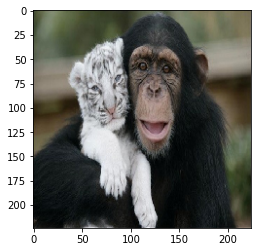

In [8]:
plt.imshow(img/255)

In [9]:
#making prediction

preds = np.round(model.predict(preprocess_input(np.expand_dims(img.copy(), axis=0))),3)
preds_data = dict(zip(class_names.values(), preds[0]))


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


<function matplotlib.pyplot.show(close=None, block=None)>

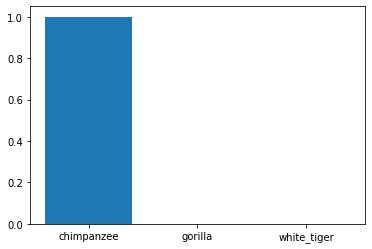

In [10]:
#plot results
plt.bar(range(len(preds_data)), list(preds_data.values()), align='center')
plt.xticks(range(len(preds_data)), list(preds_data.keys()))
plt.show

In [11]:
# defining shap vals layer method

def shap_vals_layer(n):
  # explain how the input to the "n" layer of the model explains the top two classes
  def map2layer(x, layer):
      feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
      return K.get_session().run(model.layers[layer].input, feed_dict)
  e = shap.GradientExplainer(
      (model.layers[n].input, model.layers[-1].output),
      map2layer(X, n),
      local_smoothing=1 # std dev of smoothing noise
  )

  shap_values,indexes = e.shap_values(map2layer(to_explain, n),ranked_outputs=3)
  return (shap_values,indexes)

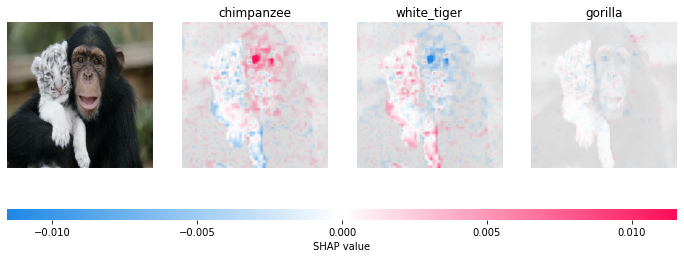

In [12]:
# plot explanation for the 7th layer
shap.image_plot(shap_vals_layer(7)[0],to_explain,np.vectorize(lambda x: class_names[str(x)])(shap_vals_layer(7)[1]))

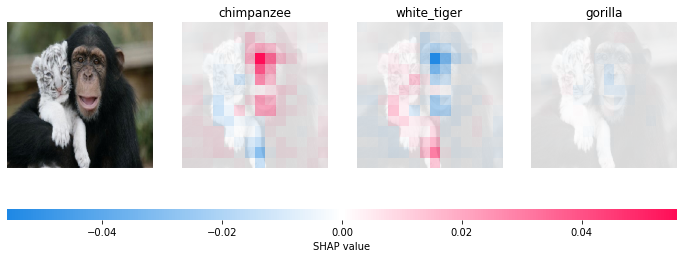

In [13]:
# plot explanation for the 15th layer
shap.image_plot(shap_vals_layer(15)[0],to_explain,np.vectorize(lambda x: class_names[str(x)])(shap_vals_layer(15)[1]))